# Alignment

This demo shows how to align all multi-view models. 



### About model coordinate

Firstly, we would like explain the coordinate definition of the TU models and the multi-view models in FaceScape dataset.
 
 * The TU models (obj files) are in a canonical coordinate. Specifically speaking, all the mesh models of various identity and expressions are roughly aligned to each other. In these mesh models, the faces are always pointing to the positive direction of Z axis, and the tops of the heads are always pointing to the positive direction of the Y axis. The scales of all TU models are uniform, and the unit is millimetter.
 
 * The multi-view models (ply files) are in the coordinates generated by Structure-from-Motion algorithm with uncertain initialization.  Therefore, the coordinates and the scales of multi-view models differ from each other, and the camera parameters for each model are not uniform.  To align all the multi-view models, one may just trasform all multi-view models to the coordinates of TU-models.  One demo is provided to align two sample multi-view models below.

Please note that the provided scale and Rt can not align perfectly. There is still minor misalignment.

### Demo

Firstly, make sure the environment and sample data have been prepared following [README-toolkit](https://github.com/zhuhao-nju/facescape/blob/master/toolkit/README.md). Then run the demo:

In [1]:
import trimesh, json, os
import numpy as np

# read multi-view mesh
mview_mesh = trimesh.load("../samples/sample_mview_data/4_anger.ply", process=False)

id_idx = 212 # identity index of this sample is 212
exp_idx = 4 # expression index of this sample is 4_angler

# read Rt scale
with open("./predef/Rt_scale_dict.json", 'r') as f:
    Rt_scale_dict = json.load(f)
    scale = Rt_scale_dict['%d'%id_idx]['%d'%exp_idx][0]
    Rt = np.array(Rt_scale_dict['%d'%id_idx]['%d'%exp_idx][1])

# align multi-view model to TU model
mview_mesh.vertices *= scale
mview_mesh.vertices = np.tensordot(Rt[:3,:3], mview_mesh.vertices.T, 1).T + Rt[:3, 3]

os.makedirs("./demo_output/", exist_ok=True)
mview_mesh.export("./demo_output/4_anger_canocical.ply")
print("aligned mview_model saved to ./demo_output/4_anger_canocical.ply")


aligned mview_model saved to ./demo_output/4_anger_canocical.ply


The result is saved as "./demo_output/4_anger_canocical.ply". By rendering this result model and "../samples/sample_tu_model/1_neutral.obj" with the same camera parameter, we can see the transformed multi-view model has been algned to the TU model:

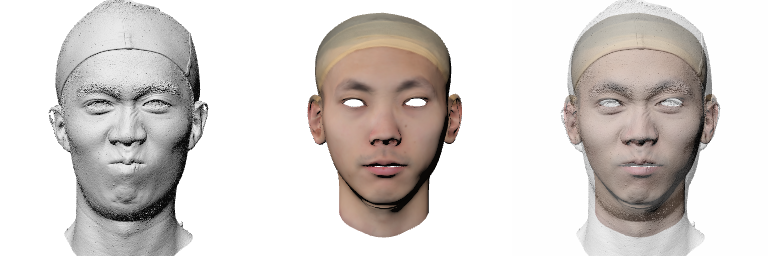

In [2]:
import src.renderer as renderer
import src.utility as util

# set camera parameters
K = np.array([[1000, 0, 128],
              [0, 1000, 128],
              [0, 0, 1]], dtype=np.float64)

Rt = np.array([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 1200]], dtype=np.float64)

h, w = 256, 256

# render the aligned multi-view model
_, rend_mview_model = renderer.render_cvcam(mview_mesh, K, Rt, rend_size=(h, w), 
                                            flat_shading=False)

# render the TU model
tu_base_mesh = trimesh.load("../samples/sample_tu_model/1_neutral.obj", process=False)
tu_base_mesh.visual.material.diffuse = np.array([255, 255, 255, 255], dtype=np.uint8)

_, rend_tu_model = renderer.render_cvcam(tu_base_mesh, K, Rt, rend_size=(h, w), 
                                         flat_shading=False)

merge_img = (rend_mview_model//2) + (rend_tu_model//2)
vis_img = np.concatenate((rend_mview_model, rend_tu_model, merge_img), 1)
util.show_img_arr(vis_img, bgr_mode = True)